# Qanvast, Interior Design Vendor Management System - Part 2

# Notebook Brief

This notebook contains the reviews extraction and text analysis for topic modelling. 

## 1.0 Data Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy 
import en_core_web_sm
    
from spacy.matcher import Matcher
from spacy.tokens import span, token

from nltk import bigrams

In [4]:
nlp = en_core_web_sm.load()

In [5]:
#import data 
qvst = pd.read_csv('./data/cleaned_qvst.csv')

In [6]:
qvst.head(1)

,projectCompletionDate,projectCost,country,designRating,workmanshipRating,professionalismRating,projectManagementRating,createdAt,averageRating,company,total_reviews,reviews,word_count
0,2021-07-31 16:00:00+00:00,0.0,SG,5,5,5,5,2021-05-31 13:44:41.680000+00:00,5.0,TodzTerior,18,Review of Thomas from Todz'Terior I'm thankful...,92


## 2.0 Data Cleaning and Processing

In [7]:
stop_words=spacy.lang.en.stop_words.STOP_WORDS
nlp.Defaults.stop_words |= {"recommend","recommending","review", "renovation", "project", "interior", "designer", "ID", "home", "house", "complete","want"}
print(nlp.Defaults.stop_words)

{'from', 'cannot', 'off', 'until', 'least', 'what', 'too', 'always', 'four', 'will', "n't", 'often', 'noone', 'on', 'unless', 'all', 'their', 'it', 'alone', 'get', 'formerly', 'much', 'nothing', 'upon', 'whence', 'next', 'because', 'whom', 'whither', 'only', 'any', 'put', 'thence', 'into', 'we', 'however', 'meanwhile', 'become', 'am', 'front', 'already', 'they', 'well', 'afterwards', "'d", 'if', 'he', 'empty', 'interior', 'give', 'that', 'sometimes', 'although', '‘m', 'twelve', '’ve', 'before', 'her', 'more', 'seem', 'used', 'therefore', 'really', 'against', 'may', 'yourselves', 'everything', 'forty', 'together', 'across', 'where', 'your', 'herself', 'again', 'neither', 'than', 'above', 'even', 'elsewhere', 'still', 'take', '‘ve', 'less', 'ten', 'has', 'same', 'why', 'whereafter', 'being', 'one', 'his', 'with', 'whereas', 'should', 'latter', 'between', 'i', 'while', 'n‘t', 'anyway', 'complete', 'through', 'somewhere', 'beyond', 'the', 'throughout', 'him', 'former', 'behind', 'three', '

In [8]:
def clean_text(text):
    ''' 
    Cleans basic text to remove \n
    
    '''
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    return text

def preprocess(text):
    ''' 
       Input: Text 
       Output: Tokenized, removed stop words and whitespaces token in list
    
    '''
    text = clean_text(text)
   
    #process nlp
    doc = nlp(text)
    
    # Create list of word tokens
    person = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    token_list = []
    for token in doc:
        if not token.ent_type:
            token_list.append(token.lemma_)
            
#    ngrams
    for chunk in doc.noun_chunks:
        if not person:
            token_list.append(chunk.text)
    
        
    # Create list of word tokens after removing stopwords and punctuation
    filtered_sentence =[] 
    for word in token_list:
        lexeme = nlp.vocab[word]
        if (lexeme.is_stop == False) & (lexeme.is_punct == False) & (lexeme.text.isspace() == False) & (lexeme != 'ID'):
            filtered_sentence.append(word) 
            print('\rWaiting... {} index remaining... '.format(np.random.random()), end='.')

    return filtered_sentence

In [9]:
#sample row 3 for testing
doc_sample = qvst.reviews[3]
    
print(doc_sample)
print('\n')
print(preprocess(doc_sample))  


GREAT WORK -JIN LING, PROJECT GURU Prior to engaging Jin Ling from Project Guru, we went to a few other ID firms however, in the end we decided on Jin Ling was the one for us because we feel that she’s may be able to deliver what we are looking for within our budget. She never disappoint.

Throughout the whole renovations period, work was done systematically to the timeline drafted by her. Right from the beginning, Jin Ling suggested to have a whatapps group so that we can always discuss issues and be on the same page. We often get updates with photos + videos of our house from Jin Ling. She responded to every question and concern that we have. During renovations, small hiccups here and there is normal but Jin Ling was quick to rectify issues that surfaced (attached examples of before & after rectified work). 

Overall, the whole renovation was a breeze and enjoyable. Great work done and we really appreciate seeing our dream home from 3D drawing coming to life. Moving forward, I see my

In [10]:
processed_doc = qvst.reviews.map(preprocess)

Waiting... 0.5847267030012817 index remaining... .......................................................

In [11]:
processed_doc

0       [Todz'Terior, -PRON-, thankful, provide, compr...
1       [beautiful, thank, MSS, big, thank, -PRON-, Re...
2       [attention, detail, stress, free, experience, ...
3       [great, WORK, -JIN, ling, GURU, prior, engage,...
4       [average, id, firm, meet, friendly, able, prop...
                              ...                        
8610    [wife, friend, previously, engage, -PRON-, -PR...
8611    [Kenn, reason, -PRON-, decide, engage, renovat...
8612    [-PRON-, problem, -PRON-, previous, -PRON-, gl...
8613    [-PRON-, good, experience, work, -PRON-, good,...
8614    [-PRON-, friend, acquaintance, -PRON-, decide,...
Name: reviews, Length: 8615, dtype: object

In [12]:
import pickle 
pickle.dump(processed_doc, open('./processed_doc.data', 'wb'))

## Topic Modelling 

In [13]:
#import processed data

import pickle
processed_doc = pickle.load(open('./processed_doc.data', 'rb'))

In [14]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser

from gensim.models import CoherenceModel

In [15]:
#Number of times a word appear in training set
#dict to map word to unique ID
dictionary = gensim.corpora.Dictionary(processed_doc)

#sample dict
count = 0 
for k, v in dictionary.iteritems():
    print(k,v)
    count+=1
    if count > 10:
        break

0 -PRON-
1 Todz'Terior
2 advice
3 approachable
4 comprehensive
5 dealing
6 discount
7 ensure
8 free
9 friendly
10 include


In [16]:
#filter token that appear less than 20 docs, or more than 0.25 doc, keep only 100,000 most frequent token
dictionary.filter_extremes(no_below=20, no_above=0.25, keep_n=100000)

In [17]:
#each doc, dictionary indicating how many words and time it appears
#corpus 
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_doc]

In [18]:
#sample corpus on  index 10 
bow_doc_11 = bow_corpus[11]
for i in range(len(bow_doc_11)):
    
    print(f"Word {bow_doc_11[i][0]} (\"{dictionary[bow_doc_11[i][0]]}\") appears {bow_doc_11[i][1]} time.")

Word 0 ("advice") appears 1 time.
Word 15 ("quick") appears 2 time.
Word 40 ("certain") appears 1 time.
Word 43 ("come") appears 2 time.
Word 48 ("consult") appears 2 time.
Word 59 ("end") appears 1 time.
Word 61 ("excellent") appears 1 time.
Word 62 ("expectation") appears 1 time.
Word 69 ("firm") appears 1 time.
Word 72 ("great") appears 1 time.
Word 73 ("handover") appears 1 time.
Word 77 ("highly") appears 1 time.
Word 82 ("initial") appears 1 time.
Word 93 ("manpower") appears 1 time.
Word 101 ("notice") appears 1 time.
Word 107 ("point") appears 1 time.
Word 109 ("quality") appears 1 time.
Word 116 ("sense") appears 1 time.
Word 135 ("workmanship") appears 1 time.
Word 137 ("attention") appears 1 time.
Word 140 ("check") appears 1 time.
Word 143 ("detail") appears 2 time.
Word 144 ("incorporate") appears 1 time.
Word 146 ("money") appears 1 time.
Word 147 ("owner") appears 2 time.
Word 156 ("appreciate") appears 1 time.
Word 159 ("breeze") appears 1 time.
Word 162 ("deliver") app

In [19]:
#lda instantitate 3 topics
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=2, workers=2, minimum_probability=0.0)

for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx} \n Words: {topic}')

Topic 0 
 Words: 0.011*"come" + 0.010*"friend" + 0.009*"thing" + 0.009*"issue" + 0.008*"cost" + 0.008*"decide" + 0.007*"look" + 0.007*"great" + 0.007*"workmanship" + 0.007*"know"
Topic 1 
 Words: 0.009*"come" + 0.008*"feel" + 0.008*"provide" + 0.008*"friend" + 0.007*"decide" + 0.007*"request" + 0.007*"thing" + 0.007*"look" + 0.007*"issue" + 0.007*"change"
Topic 2 
 Words: 0.010*"team" + 0.010*"great" + 0.009*"look" + 0.008*"job" + 0.008*"friend" + 0.008*"provide" + 0.007*"workmanship" + 0.007*"quality" + 0.006*"come" + 0.006*"update"


In [20]:
#sample output
for index, score in sorted(lda_model[bow_corpus[5]], key=lambda tup: -1*tup[1]):
    print(f"\nScore: {score}\t \nTopic: {lda_model.print_topic(index, 5)}")


Score: 0.9020271897315979	 
Topic: 0.009*"come" + 0.008*"feel" + 0.008*"provide" + 0.008*"friend" + 0.007*"decide"

Score: 0.077826127409935	 
Topic: 0.010*"team" + 0.010*"great" + 0.009*"look" + 0.008*"job" + 0.008*"friend"

Score: 0.020146677270531654	 
Topic: 0.011*"come" + 0.010*"friend" + 0.009*"thing" + 0.009*"issue" + 0.008*"cost"


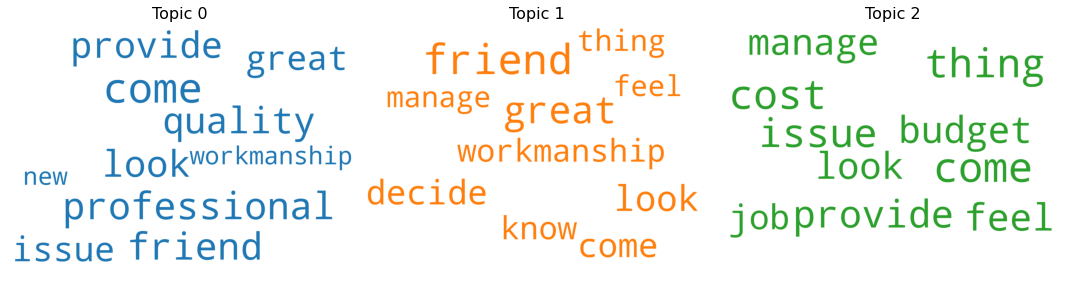

In [76]:
#### import wordcloud
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,20))
axes = axes.ravel()

for i, ax in enumerate(axes.flatten()):
    if i>=4:
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=-30)
plt.show()

Total 3 topics are identifiied with general outline on the following. 

1. Topic 0: Professionality and Quality 
2. Topic 1: Workmanship Design 
3. Topic 2: Cost , Budget


### 2.1 Topic to Dataframe

In [36]:
all_topics = lda_model .get_document_topics(bow_corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

In [37]:
all_topics_df.head(10)

,0,1,2
0,0.013336,0.972596,0.014068
1,0.002476,0.462133,0.535392
2,0.010772,0.011317,0.977911
3,0.167661,0.264882,0.567456
4,0.511346,0.007193,0.481461
5,0.020147,0.919930,0.059923
6,0.695599,0.008184,0.296217
7,0.176348,0.625379,0.198273
8,0.012199,0.975039,0.012762
9,0.810567,0.023076,0.166357


In [38]:
#select max prob topic
all_topics_df['topic'] = all_topics_df.idxmax(axis=1)

#extract val with highest proba
all_topics_df['topic_proba'] = np.max(all_topics_df[[0,1,2]], axis=1)

In [45]:
qvst['topics'] = all_topics_df.topic

## 3.0 Export Model

In [29]:
#export best model
pickle.dump(lda_model, open('./ldamodel_doc.pkl', 'wb'))

More exploratory on the text sentiment in the next notebook.